# ~XYZ~ atvirų duomenų analizė

Data: ~2019-12-03~

Autorius: © 2019 Algirdas Kartavičius, (kontaktas/nuoroda)~. 

## Analizė atsako į šiuos klausimus:
1. ~[Pirmas MP1 klausimas](#Pirmas-MP1-klausimas?)~?
1. ~[Antras MP1 klausimas](#Pirmas-MP1-klausimas?)~?
1. ~[Trečias MP1 klausimas](#Trečias-MP1-klausimas?)~? (MM)
1. [Kokiu tikslumu galima nustatyti automobilio kuro-rūšį pagal pirmos registracijos datą, sandorio datą ir kainą?](#Kokiu-tikslumu-galima-nustatyti-automobilio-kuro-rūšį-pagal--pirmos-registracijos-datą,-sandorio-datą-ir-kainą?) (MM2)
1. [Kokiu tikslumu galima nustatyti automobilio markę pagal pagaminimo datą, sandorio datą, galią, darbinį tūrį ir kainą?](#Kokiu-tikslumu-galima-nustatyti-automobilio-markę-pagal-pagaminimo-datą,-sandorio-datą,-galią,-darbinį-tūrį-ir-kainą?) (MM2)
1. [Kokiu tikslumu galima nustatyti automobilio kainą](#Kokiu-tikslumu-galima-nustatyti-automobilio-kainą?) (MM2)

## Pasitelkiami duomenų šaltiniai:
* ~[https://www.epolicija.lt/atviri-duomenys](https://www.epolicija.lt/atviri-duomenys)~

Šis sąsiuvinis yra platinamas pagal <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Priskyrimas 4.0 Tarptautinė licenciją</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

Jis yra dalis atsiskaitymo [KTU IF](https://if.ktu.edu/) kurse [P176M010 "Pažangus mašininis mokymasis"](https://stojantiesiems.ktu.edu/programme/m-programu-sistemu-inzinerija/#P176M010), kurį veda [M. Lukoševičius](http://mantas.info/).

## Įsikeliame duomenis

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import io, requests
sns.set()
import datetime as dt
from datetime import date
import zipfile
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Nusiskaitome ...

In [33]:
zf = zipfile.ZipFile('data2.zip')
raw_data = pd.read_csv(zf.open('exported_car_model_data.csv'), sep=',', error_bad_lines=False, index_col=False, encoding="ISO-8859-1") 
raw_data.head()

C:\Algirdo\Magistras\MasininisMokymasis\WPy64-3740\python-3.7.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,MARKE,PIRM_REG_DATA_LT,PASKUTINES_REG_DATA,DEGALAI,KILMES_SALIS,SANDORIO_SUMA,VALIUTA,SANDORIO_DATA,GALIA,DARBINIS_TURIS,PIRM_REG_DATA
0,MAZDA,2016-01-04,2016-01-04,Dyzelinas,NaN,25000.0,EUR,2015-01-04,110.0,2191.0,2016-01-04
1,SUBARU,2016-01-06,2016-01-06,Benzinas,NaN,33900.0,EUR,2015-01-04,129.0,2498.0,2016-01-06
2,HYUNDAI,2016-01-11,2016-01-11,Dyzelinas,SWE,700.0,EUR,2015-01-05,83.0,1991.0,2002-06-27
3,MERCEDES BENZ,2016-01-13,2016-01-13,Dyzelinas,DEU,3500.0,EUR,2015-01-12,90.0,2874.0,1997-09-29
4,LOHR,2016-01-12,2016-01-12,--,FRA,NaN,EUR,2015-01-15,NaN,NaN,1999-10-11


...

## ~Pirmas MP1 klausimas~?

## ~Antras MP1 klausimas~?

## ~Trečias MP1 klausimas~?

##  Kokiu tikslumu galima nustatyti automobilio kuro rūšį pagal  pirmos registracijos datą, sandorio datą ir kainą?

Išfiltruojam eilutes, kuriose yra visi reikiami laukai bei valiuta yra €.   
Po to pasirenkama automobilius, kurių kuras Dyzelinas arba Benzinas, kadangi kitų rūšių yra per mažai duomenų.

In [34]:
fuel_data = raw_data[raw_data['DEGALAI'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
fuel_data = fuel_data.drop(['MARKE', 'PIRM_REG_DATA_LT', 'PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA'], axis='columns')
fuel_data = fuel_data[(fuel_data['DEGALAI'] == 'Dyzelinas') | (fuel_data['DEGALAI'] == 'Benzinas')]
fuel_data['SANDORIO_DATA'] = pd.to_datetime(fuel_data['SANDORIO_DATA'], errors='coerce')
fuel_data['PIRM_REG_DATA'] = pd.to_datetime(fuel_data['PIRM_REG_DATA'], errors='coerce')
fuel_data['SANDORIO_DATA_DAYS'] = (date.today() - fuel_data['SANDORIO_DATA'].dt.date).dt.days
fuel_data['PIRM_REG_DATA_DAYS'] = (date.today() - fuel_data['PIRM_REG_DATA'].dt.date).dt.days
fuel_data = fuel_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA', 'DARBINIS_TURIS', 'GALIA'], axis='columns')
fuel_data = fuel_data[fuel_data['PIRM_REG_DATA_DAYS'] > 0]
fuel_data = fuel_data[fuel_data['SANDORIO_DATA_DAYS'] > 0]
fuel_data

,DEGALAI,SANDORIO_SUMA,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
0,Dyzelinas,25000.00,1792,1427
1,Benzinas,33900.00,1792,1425
2,Dyzelinas,700.00,1791,6366
3,Dyzelinas,3500.00,1784,8098
5,Benzinas,11700.00,1776,1418
8,Dyzelinas,9000.00,1642,8521
9,Dyzelinas,38500.00,1640,1427
12,Dyzelinas,22000.00,1601,6813
13,Dyzelinas,71245.00,1599,1426
14,Dyzelinas,71245.00,1599,1426


In [35]:
df0 = fuel_data[fuel_data['DEGALAI'] == "Benzinas" ]
len(df0)

25889

In [36]:
df1 = fuel_data[fuel_data['DEGALAI'] == "Dyzelinas" ].head(len(df0))
len(df1)

25889

In [37]:
fuel_data = pd.concat([df0, df1])
len(fuel_data)

51778

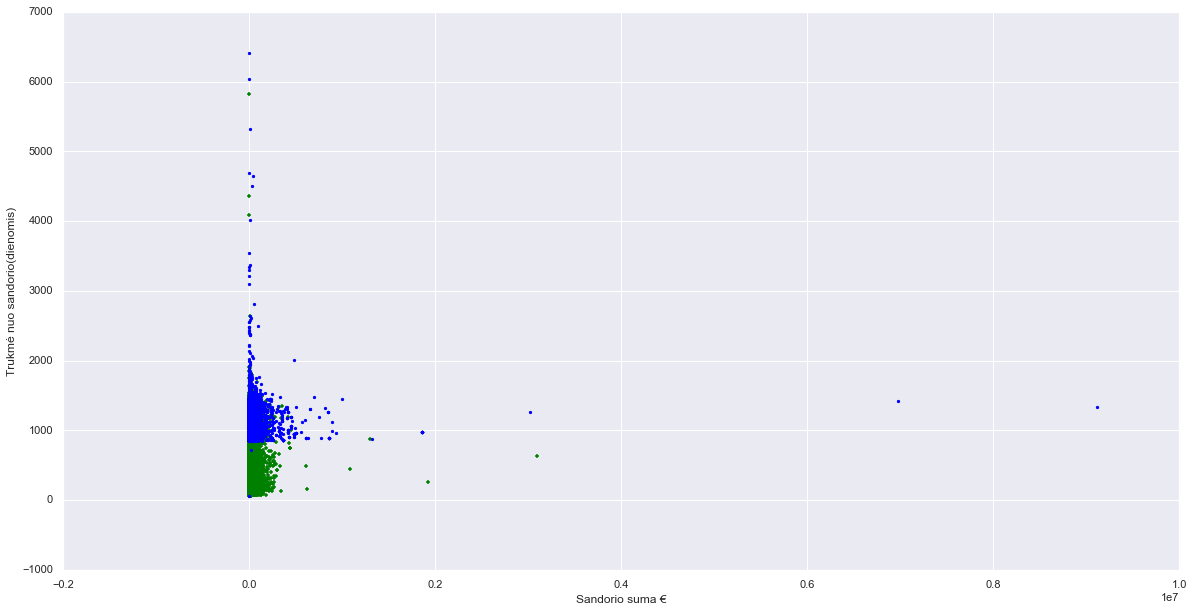

In [38]:
plt.figure(figsize=(20,10))
plt.xlabel('Sandorio suma €')
plt.ylabel('Trukmė nuo sandorio(dienomis)')
plt.scatter(df0['SANDORIO_SUMA'], df0['SANDORIO_DATA_DAYS'],color="green",marker='+')
plt.scatter(df1['SANDORIO_SUMA'], df1['SANDORIO_DATA_DAYS'],color="blue",marker='.')

### Pasirenkamas K artimiausių kaimynų klasifikatorius

In [39]:
X = fuel_data.drop(['DEGALAI'], axis='columns')
y = fuel_data['DEGALAI']

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(len(X_train))
print(len(X_test))



44011
7767


In [41]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [42]:
best_k = -1
best_score = -1
for k in range(7,10):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if score > best_score:
        best_score = score
        best_k = k


In [43]:
print('Geriausias K parametras: ' + str(best_k))
print('Gautas tikslumas: ' + str(best_score))

Geriausias K parametras: 7
Gautas tikslumas: 0.8824513969357538


## Kokiu tikslumu galima nustatyti automobilio markę pagal pagaminimo datą, sandorio datą, galią, darbinį tūrį ir kainą?


In [168]:
brand_data = raw_data[raw_data['MARKE'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
brand_data = brand_data.drop(['PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA',  'DEGALAI', 'PIRM_REG_DATA_LT'], axis='columns')
brand_data = brand_data[
                          (brand_data['MARKE'] == 'VOLKSWAGEN') 
                        | (brand_data['MARKE'] == 'AUDI')
                        | (brand_data['MARKE'] == 'TOYOTA')
                        | (brand_data['MARKE'] == 'BMW')
                        | (brand_data['MARKE'] == 'OPEL')
                        | (brand_data['MARKE'] == 'MERCEDES BENZ')
                       ]

brand_data.head()

,MARKE,SANDORIO_SUMA,SANDORIO_DATA,GALIA,DARBINIS_TURIS,PIRM_REG_DATA
3,MERCEDES BENZ,3500.0,2015-01-12,90.0,2874.0,1997-09-29
7,VOLKSWAGEN,900.0,2015-04-12,55.0,1781.0,1994-05-02
13,VOLKSWAGEN,71245.0,2015-07-16,103.0,1968.0,2016-01-05
14,VOLKSWAGEN,71245.0,2015-07-16,103.0,1968.0,2016-01-05
15,BMW,78854.0,2015-07-20,225.0,2979.0,2016-01-11


In [169]:
brand_data['SANDORIO_DATA'] = pd.to_datetime(brand_data['SANDORIO_DATA'], errors='coerce')
brand_data['PIRM_REG_DATA'] = pd.to_datetime(brand_data['PIRM_REG_DATA'], errors='coerce')
brand_data['SANDORIO_DATA_DAYS'] = (date.today() - brand_data['SANDORIO_DATA'].dt.date).dt.days
brand_data['PIRM_REG_DATA_DAYS'] = (date.today() - brand_data['PIRM_REG_DATA'].dt.date).dt.days

brand_data = brand_data[brand_data['PIRM_REG_DATA_DAYS'] > 0]
brand_data = brand_data[brand_data['SANDORIO_DATA_DAYS'] > 0]
brand_data = brand_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA'], axis='columns')
brand_data.head()

,MARKE,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
3,MERCEDES BENZ,3500.0,90.0,2874.0,1784,8098
7,VOLKSWAGEN,900.0,55.0,1781.0,1694,9344
13,VOLKSWAGEN,71245.0,103.0,1968.0,1599,1426
14,VOLKSWAGEN,71245.0,103.0,1968.0,1599,1426
15,BMW,78854.0,225.0,2979.0,1595,1420


In [170]:
X1 = brand_data.drop(['MARKE'], axis='columns')
y1 = brand_data['MARKE']

### Pasirenkamas atsitiktinių miškų klasifikatorius

In [171]:

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15)

print(len(X1_train))
print(len(X1_test))


52525
9270


In [172]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X1_train)
X1_train = scaling.transform(X1_train)
X1_test = scaling.transform(X1_test)

In [173]:
model1 = RandomForestClassifier(n_estimators=150, random_state=15)
model1.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [174]:
model1.score(X1_test, y1_test)

0.9622437971952535

## Kokiu tikslumu galima nustatyti automobilio kainą?

In [272]:
price_data = raw_data[raw_data['MARKE'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
price_data = price_data[
                          (price_data['MARKE'] == 'VOLKSWAGEN') 
                        | (price_data['MARKE'] == 'AUDI')
                        | (price_data['MARKE'] == 'TOYOTA')
                        | (price_data['MARKE'] == 'BMW')
                        | (price_data['MARKE'] == 'OPEL')
                        | (price_data['MARKE'] == 'MERCEDES BENZ')
                       ]


price_data = price_data[(price_data['DEGALAI'] == 'Dyzelinas') | (price_data['DEGALAI'] == 'Benzinas')]

price_data = price_data.drop(['PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA',  'PIRM_REG_DATA_LT'], axis='columns')

price_data.head()

,MARKE,DEGALAI,SANDORIO_SUMA,SANDORIO_DATA,GALIA,DARBINIS_TURIS,PIRM_REG_DATA
3,MERCEDES BENZ,Dyzelinas,3500.0,2015-01-12,90.0,2874.0,1997-09-29
13,VOLKSWAGEN,Dyzelinas,71245.0,2015-07-16,103.0,1968.0,2016-01-05
14,VOLKSWAGEN,Dyzelinas,71245.0,2015-07-16,103.0,1968.0,2016-01-05
15,BMW,Benzinas,78854.0,2015-07-20,225.0,2979.0,2016-01-11
20,BMW,Benzinas,42814.8,2015-08-26,135.0,1997.0,2016-01-14


In [273]:
price_data['SANDORIO_DATA'] = pd.to_datetime(price_data['SANDORIO_DATA'], errors='coerce')
price_data['PIRM_REG_DATA'] = pd.to_datetime(price_data['PIRM_REG_DATA'], errors='coerce')
price_data['SANDORIO_DATA_DAYS'] = (date.today() - price_data['SANDORIO_DATA'].dt.date).dt.days
price_data['PIRM_REG_DATA_DAYS'] = (date.today() - price_data['PIRM_REG_DATA'].dt.date).dt.days
price_data = price_data[price_data['PIRM_REG_DATA_DAYS'] > 0]
price_data = price_data[price_data['SANDORIO_DATA_DAYS'] > 0]
price_data = price_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA'], axis='columns')


Nuspręsta kainų prognozę vykdyti nuo 1000 iki 50000 €, kadangi pigesnių ir brangesnių automobilių yra labai nedaug duomenų ir jie stipriai paveikia bendrą tikslumą.  
Prognozė atliekama dešim tikslumu.

In [274]:
price_data = price_data[price_data['SANDORIO_SUMA'] > 1000]
price_data = price_data[price_data['SANDORIO_SUMA'] < 50000]
price_data.head()

,MARKE,DEGALAI,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
3,MERCEDES BENZ,Dyzelinas,3500.0,90.0,2874.0,1784,8098
20,BMW,Benzinas,42814.8,135.0,1997.0,1558,1417
21,VOLKSWAGEN,Dyzelinas,1115.5,80.0,2460.0,1545,7240
22,BMW,Benzinas,21700.0,110.0,1499.0,1542,1412
24,VOLKSWAGEN,Dyzelinas,20050.0,81.0,1968.0,1539,1412


In [275]:
from sklearn.utils import shuffle
price_data = shuffle(price_data)
price_data = price_data.head(10000)

### One hot encoding

In [276]:
X2 = price_data
X2 = pd.get_dummies(data=X2)
X2

,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS,MARKE_AUDI,MARKE_BMW,MARKE_MERCEDES BENZ,MARKE_OPEL,MARKE_TOYOTA,MARKE_VOLKSWAGEN,DEGALAI_Benzinas,DEGALAI_Dyzelinas
647668,10300.00,180.0,2967.0,284,2671,1,0,0,0,0,0,0,1
176438,3500.00,77.0,1896.0,921,4353,0,0,0,0,0,1,0,1
152659,1020.00,110.0,2496.0,1200,7885,1,0,0,0,0,0,0,1
684395,15700.00,250.0,4134.0,93,2425,0,0,0,0,0,1,0,1
137472,35574.00,140.0,1995.0,2064,1332,0,1,0,0,0,0,0,1
609003,2000.00,77.0,1896.0,512,4309,0,0,0,0,0,1,0,1
689244,1300.00,103.0,1968.0,66,5057,0,0,0,0,0,1,0,1
181409,2000.00,88.0,2171.0,865,5823,0,0,0,1,0,0,0,1
682913,3000.00,77.0,1896.0,98,4041,0,0,0,0,0,1,0,1
159140,11900.00,118.0,1956.0,1118,2785,0,0,0,1,0,0,0,1


In [277]:
X2 = X2.drop([ 'SANDORIO_SUMA'], axis='columns')
y2 = price_data['SANDORIO_SUMA']

In [278]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

print(len(X2_train))
print(len(X2_test))


8000
2000


In [279]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X2_train)
X2_train = scaling.transform(X2_train)
X2_test = scaling.transform(X2_test)

In [280]:


gbr = GradientBoostingRegressor(loss ='ls', max_depth=5)

gbr.fit (X2_train, y2_train)
score = gbr.score(X2_test, y2_test)
predicted = gbr.predict(X2_test)
difference = y2_test - predicted

In [281]:
rmse = np.sqrt(mean_squared_error(y2_test, predicted))
scores = cross_val_score(gbr, X2, y2, cv=5)

In [282]:

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

print('Variance score: %.2f' % r2_score(y2_test, predicted))


Cross Validation Scores:
[0.8511967  0.85758669 0.85387559 0.84875907 0.85635664]

Mean Score:
0.85355493562784

RMSE:
4644.950552433094
Variance score: 0.86


## Išvados, pastebėjimai

...